# Cryptocurrency market predictions
Jakub Pacierpnik, Kacper Olejak

##Imports & Settings

In [ ]:
pip install python-binance

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3721    0  3721    0     0  15312      0 --:--:-- --:--:-- --:--:-- 15312
100  503k  100  503k    0     0   768k      0 --:--:-- --:--:-- --:--:--  768k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3701    0  3701    0     0  17708      0 --:--:-- --:--:-- --:--:-- 17708
100  406k  100  406k    0     0   662k      0 --:--:-- --:--:-- --:--:--  662k


In [ ]:
from binance.client import Client
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
from fastprogress import progress_bar
import random

## Load Data

Firstly, we download all available historical data for a given cryptocurrency and given time frequency using Binance API. </br> We are interested only in closing price and timestamps that we are going to use as our indices.

In [ ]:
binance_api_key = '[jedCcn6JHS8o7xWc7y4gUIUoLD60AyOzbVCM6PlIGYmlnA9LvPXfn1jyu0sqYOjP]'   
binance_api_secret = '[mVQDZnh8Nlt9wfvYbt7OY93BG2rh1moO6KyDTRPz8hAkTIhIvMzsAg6WLERKjXoL]'
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)

def get_data(symbol, interval):
    klines = binance_client.get_historical_klines(symbol=symbol, interval=interval, start_str='2017-01-01 00:00:00', end_str='2021-06-16 00:00:00')
    data_df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])
    data_df = data_df.drop(columns=['open', 'high', 'low', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])
    data_df['timestamp'] = pd.to_datetime(data_df['timestamp'], unit='ms')
    data_df.set_index('timestamp', inplace=True)
    return data_df

Then we use TA-Lib to calculate chosen technical indicators and we concatenate both dataframes to get our complete dataset.

In [ ]:
price_series = get_data('DOTUSDT', '1h').astype(float).squeeze()
rsi_series = talib.RSI(price_series)
macdhist_series = talib.MACD(price_series)[2]
upperband_series, middleband_series, lowerband_series = talib.BBANDS(price_series)
dot_df = pd.concat([price_series, rsi_series, macdhist_series, upperband_series, middleband_series, lowerband_series], axis=1)
dot_df.columns = ['price', 'RSI', 'MACD_HIST', 'UPPER_BBAND', 'MIDDLE_BBAND', 'LOWER_BBAND']
dot_df = dot_df.dropna()
dot_df

,price,RSI,MACD_HIST,UPPER_BBAND,MIDDLE_BBAND,LOWER_BBAND
timestamp,,,,,,
2020-08-20 08:00:00,2.8505,45.612666,-0.000170,2.880214,2.78668,2.693146
2020-08-20 09:00:00,2.8488,45.495178,0.004569,2.904130,2.80484,2.705550
2020-08-20 10:00:00,2.8500,45.601693,0.007932,2.901326,2.82796,2.754594
2020-08-20 11:00:00,2.8715,47.578340,0.011535,2.874522,2.85116,2.827798
2020-08-20 12:00:00,2.8562,46.289313,0.012723,2.872290,2.85540,2.838510
...,...,...,...,...,...,...
2021-06-15 20:00:00,23.9700,47.158945,-0.175910,24.506771,24.12620,23.745629
2021-06-15 21:00:00,24.0540,48.553146,-0.157352,24.425480,24.07960,23.733720
2021-06-15 22:00:00,24.3660,53.464470,-0.119504,24.464642,24.08980,23.714958


## Prepare Data

### Scaling

Different indicators have different range in values, we normalize them to measure performance and accuracy.

In [ ]:
scaler = MinMaxScaler()
dot_df_transformed = pd.DataFrame(scaler.fit_transform(dot_df).squeeze(), index=dot_df.index).dropna()
scaler.fit_transform(dot_df['price'].values.reshape(-1,1))
dot_df_transformed.columns = ['price', 'RSI', 'MACD_HIST', 'UPPER_BBAND', 'MIDDLE_BBAND', 'LOWER_BBAND']

### Plot original and transformed series

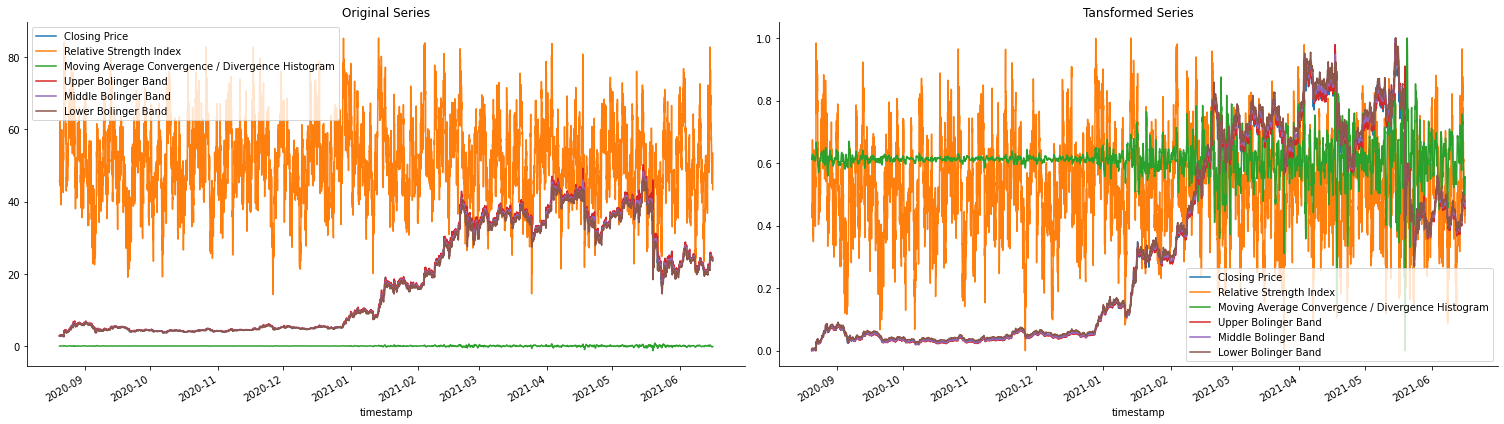

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(21,6))
columns={'price': 'Closing Price', 'RSI': 'Relative Strength Index', 'MACD_HIST': 'Moving Average Convergence / Divergence Histogram', 'UPPER_BBAND': 'Upper Bolinger Band', 'MIDDLE_BBAND': 'Middle Bolinger Band', 'LOWER_BBAND': 'Lower Bolinger Band'}
dot_df.rename(columns=columns).plot(ax=axes[0], title='Original Series')
dot_df_transformed.rename(columns=columns).plot(ax=axes[1], title='Tansformed Series')
sns.despine()
fig.tight_layout()

In [ ]:
dot_df_transformed

,price,RSI,MACD_HIST,UPPER_BBAND,MIDDLE_BBAND,LOWER_BBAND
timestamp,,,,,,
2020-08-20 08:00:00,0.003036,0.441203,0.613055,0.000180,0.000000,0.004380
2020-08-20 09:00:00,0.003000,0.439549,0.615296,0.000685,0.000399,0.004660
2020-08-20 10:00:00,0.003026,0.441049,0.616887,0.000626,0.000906,0.005767
2020-08-20 11:00:00,0.003487,0.468879,0.618591,0.000060,0.001415,0.007421
2020-08-20 12:00:00,0.003159,0.450730,0.619153,0.000013,0.001508,0.007663
...,...,...,...,...,...,...
2021-06-15 20:00:00,0.456537,0.462974,0.529947,0.456813,0.468394,0.479854
2021-06-15 21:00:00,0.458341,0.482604,0.538723,0.455097,0.467371,0.479585
2021-06-15 22:00:00,0.465041,0.551752,0.556622,0.455924,0.467595,0.479161


### Generating recurrent sequences from our time series

To apply a RNN for regression of classification, we use a sliding window to construct a rolling set of input/output pairs for our model to learn from.

We will generate sequences of 120 trading hours, approximately 5 days, and use LSTM architecture to predict the index value one timestep ahead. The input to every LSTM layer must have three dimensions, namely:

* Samples: One sequence is one sample. A batch contains one or more samples.
* Time Steps: One time step is one point of observation in the sample.
* Features: One feature is one observation at a time step.

In [ ]:
def create_multivariate_rnn_data(data, window_size):
    y = data[window_size:]
    n = data.shape[0]
    X = np.stack([data[i: j] for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y.to_numpy()

window_size = 120
X, y = create_multivariate_rnn_data(dot_df_transformed, window_size=window_size)
y = y[:, 0].reshape(-1, 1)

In [ ]:
X.shape, y.shape

((7061, 120, 6), (7061, 1))

### Making targets binary for classification

We want to generate buy/sell signals so we need to make binary targets.

In [ ]:
bin_y = pd.DataFrame(y.copy())
bin_y.columns = ['price']
bin_y['price'] = bin_y['price'].diff()
bin_y['price'][0] = 0.0
bin_y['price'] = np.where((bin_y['price'] > 0), 1.0, 0.0)
bin_y = bin_y.to_numpy()
bin_y.shape

(7061, 1)

### Train-Validation split

We are using 80/10/10 split to group observations for train/valid/test sets

In [ ]:
test_size = valid_size = 706
train_size = X.shape[0] - valid_size - test_size

In [ ]:
X_train, y_train = X[:train_size], bin_y[:train_size]

X_valid, y_valid = X[train_size:train_size+valid_size], bin_y[train_size:train_size+valid_size]

X_test, y_test = X[X.shape[0]-test_size:], bin_y[X.shape[0]-test_size:]

In [ ]:
print("Training Shape", X_train.shape, y_train.shape)
print("Validation Shape", X_valid.shape, y_valid.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (5649, 120, 6) (5649, 1)
Validation Shape (706, 120, 6) (706, 1)
Testing Shape (706, 120, 6) (706, 1)


## Define Model Architecture


Having created input/output pairs out of our time series, cut this into training/validation/testing sets, we now construct our tensors, make datasets out of them and then create dataloaders with automatic batching.


In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train))
y_train_tensors = Variable(torch.Tensor(y_train))

X_valid_tensors = Variable(torch.Tensor(X_valid))
y_valid_tensors = Variable(torch.Tensor(y_valid))

X_test_tensors = Variable(torch.Tensor(X_test))
y_test_tensors = Variable(torch.Tensor(y_test))

In [ ]:
print("Training Shape", X_train_tensors.shape, y_train_tensors.shape)
print("Validation Shape", X_valid_tensors.shape, y_valid_tensors.shape)
print("Testing Shape", X_test_tensors.shape, y_test_tensors.shape)

Training Shape torch.Size([5649, 120, 6]) torch.Size([5649, 1])
Validation Shape torch.Size([706, 120, 6]) torch.Size([706, 1])
Testing Shape torch.Size([706, 120, 6]) torch.Size([706, 1])


In [ ]:
train_dataset = TensorDataset(X_train_tensors, y_train_tensors)
train_loader = DataLoader(train_dataset, batch_size=60, shuffle=True)

valid_dataset = TensorDataset(X_valid_tensors, y_valid_tensors)
valid_loader = DataLoader(valid_dataset, batch_size=60, shuffle=True)

test_dataset = TensorDataset(X_test_tensors, y_test_tensors)
test_loader = DataLoader(test_dataset, batch_size=60, shuffle=True)

We use an architecture that consists of two stacked LSTM layers with 64 hidden units, followed by two linear layers with batch normalization and dropout, ReLU activation function and third linear layer with Sigmoid function.

In [ ]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        
        self.fc1 = nn.Linear(hidden_size, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.dp1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(32, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.dp2 = nn.Dropout(0.2)

        self.relu = nn.ReLU()

        self.fc3 = nn.Linear(16, output_size)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        _, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        
        h_n = h_n.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        
        out = self.fc1(h_n)
        out = self.bn1(out)
        out = self.dp1(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = self.dp2(out)

        out = self.relu(out)

        out = self.fc3(out)

        out = self.sigmoid(out)

        return out

## Train the Model

We train the model using the Adam optimizer and compile the model binary cross entropy loss for this classification problem. </br> We have 6 input features and one output which is from 0 to 1 depending whether price went up or down compared to the previous time step. </br> We train for 150 epochs with batch size equal to 60 and using scheduler for early stopping.

In [ ]:
input_size = 6
hidden_size = 64
num_layers = 2
output_size = 1

learning_rate = 1e-3

num_epochs = 150
min_valid_loss = np.inf
history = {'train_losses': [], 'valid_losses': []}

model = LSTM(input_size, hidden_size, num_layers, output_size)

if torch.cuda.is_available():
    model = model.cuda()

# Declaring Criterion, Optimizer and Scheduler
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, min_lr=1e-6)

for epoch in progress_bar(range(num_epochs)):
  model.train()
  train_batch_losses = []
  for data, labels in train_loader:
    # Transfer Data to GPU if available
    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()
    
    # Clear the gradients
    optimizer.zero_grad()
    # Forward Pass
    out = model(data)
    # Find the Loss
    loss = criterion(out, labels)
    # Calculate gradients
    loss.backward()
    # Update Weights
    optimizer.step()
    # Calculate Loss
    train_batch_losses.append(loss.item())
  
  train_loss = np.sum(train_batch_losses) / len(train_batch_losses)
  history['train_losses'].append(train_loss)
  
  model.eval() 
  with torch.no_grad():
    valid_batch_losses = []
    for data, labels in valid_loader:
      # Transfer Data to GPU if available
      if torch.cuda.is_available():
        data, labels = data.cuda(), labels.cuda()
      
      # Forward Pass
      out = model(data)
      # Find the Loss
      loss = criterion(out, labels)
      # Scheduler
      scheduler.step(loss)
      # Calculate Loss
      valid_batch_losses.append(loss.item())
    
    valid_loss = np.sum(valid_batch_losses) / len(valid_batch_losses)
    history['valid_losses'].append(valid_loss)

  if min_valid_loss > valid_loss:
    torch.save(model.state_dict(), 'best_model.pth')
    min_valid_loss = valid_loss

  if epoch % 10 == 0:
    print(f'Epoch {epoch} \t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')

Epoch 0 		 Training Loss: 0.7046443098027941 		 Validation Loss: 0.6979960401852926
Epoch 10 		 Training Loss: 0.6976726886252282 		 Validation Loss: 0.6916719410154555
Epoch 20 		 Training Loss: 0.6956394109087931 		 Validation Loss: 0.6920277443197038
Epoch 30 		 Training Loss: 0.697680650882318 		 Validation Loss: 0.692121856742435
Epoch 40 		 Training Loss: 0.6959244235300682 		 Validation Loss: 0.6920207308398353
Epoch 50 		 Training Loss: 0.6964178253227556 		 Validation Loss: 0.691783630185657
Epoch 60 		 Training Loss: 0.6946397755347508 		 Validation Loss: 0.6920192374123467
Epoch 70 		 Training Loss: 0.6969209275615047 		 Validation Loss: 0.6917981174257066
Epoch 80 		 Training Loss: 0.6943927541585035 		 Validation Loss: 0.6915647155708737
Epoch 90 		 Training Loss: 0.6955444716231923 		 Validation Loss: 0.6916783551375071
Epoch 100 		 Training Loss: 0.6954877687172151 		 Validation Loss: 0.6916837460464902
Epoch 110 		 Training Loss: 0.6945184460828002 		 Validation Loss: 0

## Evaluate the Results

Binary cross entropy compares each of the predicted probabilities to actual class output which can be either 0 or 1. It then calculates the score that penalizes the probabilities based on the distance from the expected value. That means how close or far our predicted trading signals are from the actual value.

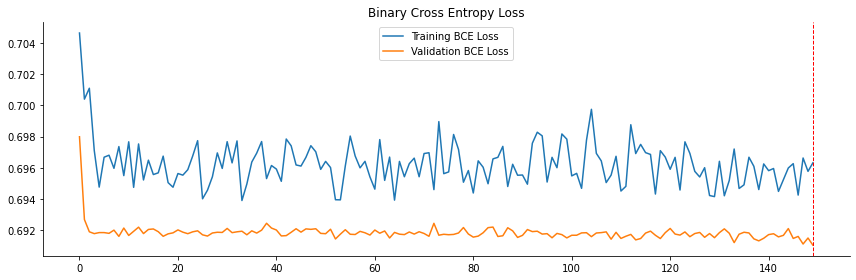

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(history)

best_epoch = loss_history.valid_losses.idxmin()

title = 'Binary Cross Entropy Loss'
loss_history.columns=['Training BCE Loss', 'Validation BCE Loss']
loss_history.plot(title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='red')

sns.despine()
fig.tight_layout()
fig.show()

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))

model.eval()

train_predict = model(X_train_tensors).detach().numpy()
valid_predict = model(X_valid_tensors).detach().numpy()
test_predict = model(X_test_tensors).detach().numpy()

train_predict_rounded = np.round(train_predict)
valid_predict_rounded = np.round(valid_predict)
test_predict_rounded = np.round(test_predict)

print(f'Training Accuracy: {(accuracy_score(y_train, train_predict_rounded) * 100): .2f}%')
print(f'Validation Accuracy: {(accuracy_score(y_valid, valid_predict_rounded) * 100): .2f}%')
print(f'Testing Accuracy: {(accuracy_score(y_test, test_predict_rounded) * 100): .2f}%')

Training Accuracy:  51.73%
Validation Accuracy:  51.84%
Testing Accuracy:  51.56%


### Trading Simulation


For testing our model we will provide a simple trading simulation 
with different strategies.
Any trade is rather buying with all amount of fiat money
or selling all cryptocurrency holdings to not favor any of them.


1.   Greedy Strategy
    *   Using binary BUY/SELL trading signals for transaction.
2.   Coin flip
    *   Coin flip is used to decide which action (buy or sell) we should make.
3.   Threshold Strategy
    *   Buys cryptocurrency if probability of price growth is higher than 0.55.
    *   Sells cryptocurrency if probability of price decrease is lower than 0.45.



In [ ]:
df_test_predict = pd.DataFrame(test_predict, index=dot_df[dot_df.shape[0]-test_size:].index)

In [ ]:
class Portfolio:
    def __init__(self, fiat_currency = dict(), crypto_holdings = dict()):
        self.fiat_currency = fiat_currency
        self.crypto_holdings = crypto_holdings


def make_transaction(currency, price, action, trading_fee = 0.001):
    if action == 'BUY':
        crypto = currency / price
        crypto *= 1 - trading_fee
        return crypto
    elif action == 'SELL':
        fiat = currency * price
        fiat *= 1 - trading_fee
        return fiat


def dolar_cost_averaging(fiat_money, holdings, trading_df):
    pass

def threshold_strategy(fiat_money, holdings, trading_df):

    for i in range(1, trading_df.shape[0]):
        if trading_df['signal'][i] > 0.54:
            holdings += make_transaction(fiat_money, trading_df['price'][i-1], 'BUY')
            fiat_money = 0
        elif trading_df['signal'][i] < 0.46:
            fiat_money += make_transaction(holdings, trading_df['price'][i-1], 'SELL')
            holdings = 0
    
    fiat_money += make_transaction(holdings, trading_df['price'][trading_df.shape[0]-1], 'SELL')
    return fiat_money

def greedy_strategy(fiat_money, holdings, trading_df):

    for i in range(1, trading_df.shape[0]):
        if trading_df['signal_rounded'][i]:
            holdings += make_transaction(fiat_money, trading_df['price'][i-1], 'BUY')
            fiat_money = 0
        else:
            fiat_money += make_transaction(holdings, trading_df['price'][i-1], 'SELL')
            holdings = 0
    
    
    fiat_money += make_transaction(holdings, trading_df['price'][trading_df.shape[0]-1], 'SELL')
    return fiat_money



def coin_flip_strategy(fiat_money, holdings, trading_df):

    for i in range(1, trading_df.shape[0]):
        if random.choice([True, False]):
            holdings += make_transaction(fiat_money, trading_df['price'][i-1], 'BUY')
            fiat_money = 0
        else:
            fiat_money += make_transaction(holdings, trading_df['price'][i-1], 'SELL')
            holdings = 0

    fiat_money += make_transaction(holdings, trading_df['price'][trading_df.shape[0]-1], 'SELL')
    return fiat_money



def simulate_trading(portfolio, trading_df, strategy, cryptocurrency, fiat):

    fiat_money = portfolio.fiat_currency[fiat]
    holdings = portfolio.crypto_holdings[cryptocurrency]

    fiat_money = strategy(fiat_money, holdings, trading_df)

    print(fiat_money)

In [ ]:
trading_df = pd.DataFrame()
trading_df['price'] = dot_df[dot_df.shape[0]-test_size:]['price']
trading_df['signal'] = df_test_predict
trading_df['signal_rounded'] = test_predict_rounded
trading_df['timestamp'] = trading_df.index
trading_df

,price,signal,signal_rounded,timestamp
timestamp,,,,
2021-05-17 15:00:00,38.035,0.506855,1.0,2021-05-17 15:00:00
2021-05-17 16:00:00,37.698,0.508730,1.0,2021-05-17 16:00:00
2021-05-17 17:00:00,37.540,0.511435,1.0,2021-05-17 17:00:00
2021-05-17 18:00:00,39.300,0.514219,1.0,2021-05-17 18:00:00
2021-05-17 19:00:00,39.936,0.512887,1.0,2021-05-17 19:00:00
...,...,...,...,...
2021-06-15 20:00:00,23.970,0.500730,1.0,2021-06-15 20:00:00
2021-06-15 21:00:00,24.054,0.501748,1.0,2021-06-15 21:00:00
2021-06-15 22:00:00,24.366,0.501797,1.0,2021-06-15 22:00:00


In [ ]:
fiat = {'USD': 1000}
crypto = {'DOT': 0}
portfolio = Portfolio(fiat, crypto)

In [ ]:
print("Coin flip strategy:")
simulate_trading(portfolio, trading_df, coin_flip_strategy, 'DOT', 'USD')

print("Greedy strategy:")
simulate_trading(portfolio, trading_df, greedy_strategy, 'DOT', 'USD')

print("Threshold strategy:")
simulate_trading(portfolio, trading_df, threshold_strategy, 'DOT', 'USD')

Coin flip strategy:
523.2286957408548
Greedy strategy:
594.7214796477851
Threshold strategy:
842.0312625275533
